In [1]:
import numpy as np
from model_vanilla_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/rot2d_aug_argminW_lr0.0002_nomaxdivision_20/checkpoint"
sample_dir = "./out/rot2d_aug_argminW_lr0.0002_nomaxdivision_20/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

zoom aug is disabled
loading mnist without augmenting ...
 [*] Reading checkpoints... ./out/rot2d_aug_argminW_lr0.0002_nomaxdivision_20/checkpoint
INFO:tensorflow:Restoring parameters from ./out/rot2d_aug_argminW_lr0.0002_nomaxdivision_20/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


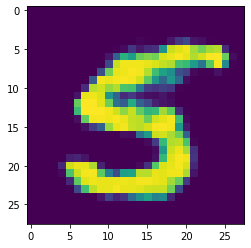

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    target_fn = np.copy(outputs_zs)
    mask_fn = np.ones(outputs_zs.shape)
#     print('rotate with alphas:', alpha)
    mask_out = np.zeros(outputs_zs.shape)

    for i in range(outputs_zs.shape[0]):
        if alpha!=0:
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), alpha, 1)
            target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
        else:
            mask_out[i,:,:,:] = mask_fn[i,:,:,:]

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

    if show_img:
        print('Target image:')
        imshow(imgrid(np.uint8(target_fn*255), cols=4))

    if show_mask:
        print('Target mask:')
        imshow(imgrid(np.uint8(mask_out*255), cols=4))

    return target_fn, mask_out


In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/rot2d_aug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 10)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-16 21:08:09,520 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.18822741508483887, 0, 0, 0.16088706254959106, -8
2019-09-16 21:08:09,529 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0072863101959228516, 0, 10, 0.21168984472751617, 7
2019-09-16 21:08:09,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007675647735595703, 0, 20, 0.16648906469345093, -8
2019-09-16 21:08:09,548 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008455514907836914, 0, 30, 0.20951826870441437, 8
2019-09-16 21:08:09,558 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008835315704345703, 0, 40, 0.06273855268955231, 1
2019-09-16 21:08:09,568 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008827447891235352, 0, 50, 0.1735517531633377, -8
2019-09-16 21:08:09,578 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008816957473754883, 0, 60, 0.1572607457637787, 5
2019-09-16 21:08:09,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009009599685668945, 0, 70, 0.136615589261055, -5
2019-09-16 21:08:09,598 [MainThre

2019-09-16 21:08:10,214 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009208202362060547, 0, 680, 0.14020776748657227, -7
2019-09-16 21:08:10,224 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009092092514038086, 0, 690, 0.14122354984283447, -9
2019-09-16 21:08:10,234 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008914709091186523, 0, 700, 0.13734053075313568, -7
2019-09-16 21:08:10,244 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008715391159057617, 0, 710, 0.14453262090682983, -3
2019-09-16 21:08:10,254 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008960723876953125, 0, 720, 0.14339037239551544, -6
2019-09-16 21:08:10,265 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009640932083129883, 0, 730, 0.1596333384513855, -8
2019-09-16 21:08:10,276 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009398937225341797, 0, 740, 0.09060407429933548, 3
2019-09-16 21:08:10,286 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008920907974243164, 0, 750, 0.06679084151983261, 1
2019-09-16 21:08:10

2019-09-16 21:08:10,894 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008679866790771484, 0, 1350, 0.1072908490896225, -3
2019-09-16 21:08:10,904 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009026765823364258, 0, 1360, 0.09265422821044922, 6
2019-09-16 21:08:10,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009010076522827148, 0, 1370, 0.1190895065665245, -4
2019-09-16 21:08:10,924 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008740663528442383, 0, 1380, 0.13533537089824677, -5
2019-09-16 21:08:10,935 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009387016296386719, 0, 1390, 0.1240033507347107, -6
2019-09-16 21:08:10,945 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00914454460144043, 0, 1400, 0.11166443675756454, 3
2019-09-16 21:08:10,955 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00886225700378418, 0, 1410, 0.10227297246456146, 3
2019-09-16 21:08:10,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009666204452514648, 0, 1420, 0.13972099125385284, -9
2019-09-16 21:08

2019-09-16 21:08:11,593 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009176015853881836, 0, 2020, 0.11170096695423126, 7
2019-09-16 21:08:11,603 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00874948501586914, 0, 2030, 0.11506659537553787, 7
2019-09-16 21:08:11,614 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009140253067016602, 0, 2040, 0.09905774146318436, 3
2019-09-16 21:08:11,624 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00885772705078125, 0, 2050, 0.1083499863743782, -3
2019-09-16 21:08:11,634 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009078741073608398, 0, 2060, 0.09948675334453583, -2
2019-09-16 21:08:11,644 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008660316467285156, 0, 2070, 0.11901924014091492, -4
2019-09-16 21:08:11,654 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009179115295410156, 0, 2080, 0.10270379483699799, 8
2019-09-16 21:08:11,664 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009031057357788086, 0, 2090, 0.051349058747291565, 1
2019-09-16 21:0

2019-09-16 21:08:12,290 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013553142547607422, 0, 2690, 0.12687651813030243, -7
2019-09-16 21:08:12,301 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010016679763793945, 0, 2700, 0.11936923116445541, -7
2019-09-16 21:08:12,312 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009198904037475586, 0, 2710, 0.11556825786828995, -3
2019-09-16 21:08:12,322 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00889277458190918, 0, 2720, 0.09139683097600937, 2
2019-09-16 21:08:12,332 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008836030960083008, 0, 2730, 0.10049799829721451, 4
2019-09-16 21:08:12,342 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00902700424194336, 0, 2740, 0.08712241798639297, 5
2019-09-16 21:08:12,353 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00936126708984375, 0, 2750, 0.0790446326136589, 3
2019-09-16 21:08:12,363 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00928640365600586, 0, 2760, 0.11437396705150604, -5
2019-09-16 21:08:

2019-09-16 21:08:12,969 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008862018585205078, 0, 3350, 0.09759172052145004, 4
2019-09-16 21:08:12,979 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008488655090332031, 0, 3360, 0.12909424304962158, -8
2019-09-16 21:08:12,989 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008981466293334961, 0, 3370, 0.10880498588085175, -4
2019-09-16 21:08:12,999 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008681535720825195, 0, 3380, 0.09078509360551834, -3
2019-09-16 21:08:13,009 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008585214614868164, 0, 3390, 0.09292661398649216, 3
2019-09-16 21:08:13,019 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008960723876953125, 0, 3400, 0.07593203336000443, -2
2019-09-16 21:08:13,029 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009168148040771484, 0, 3410, 0.12704089283943176, -6
2019-09-16 21:08:13,039 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00865936279296875, 0, 3420, 0.10245098918676376, -4
2019-09-16 

2019-09-16 21:08:13,643 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009128332138061523, 0, 4010, 0.06275257468223572, -4
2019-09-16 21:08:13,653 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009274005889892578, 0, 4020, 0.09053380787372589, -4
2019-09-16 21:08:13,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00907588005065918, 0, 4030, 0.11901821941137314, -9
2019-09-16 21:08:13,673 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008637428283691406, 0, 4040, 0.10101816803216934, 5
2019-09-16 21:08:13,683 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008709192276000977, 0, 4050, 0.07021593302488327, 2
2019-09-16 21:08:13,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008937835693359375, 0, 4060, 0.12317240983247757, -7
2019-09-16 21:08:13,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009124755859375, 0, 4070, 0.12939807772636414, 9
2019-09-16 21:08:13,714 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00953221321105957, 0, 4080, 0.09905973821878433, -6
2019-09-16 21:08

2019-09-16 21:08:14,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008537054061889648, 0, 4680, 0.06898263841867447, 4
2019-09-16 21:08:14,349 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008706092834472656, 0, 4690, 0.07765115052461624, 4
2019-09-16 21:08:14,359 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009377241134643555, 0, 4700, 0.07118521630764008, 4
2019-09-16 21:08:14,370 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009543180465698242, 0, 4710, 0.06041698157787323, 2
2019-09-16 21:08:14,380 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00888824462890625, 0, 4720, 0.05218324437737465, -2
2019-09-16 21:08:14,390 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008915185928344727, 0, 4730, 0.08945934474468231, -7
2019-09-16 21:08:14,400 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008676528930664062, 0, 4740, 0.06271662563085556, -4
2019-09-16 21:08:14,416 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014793872833251953, 0, 4750, 0.014944348484277725, 1
2019-09-16 21

2019-09-16 21:08:15,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008613109588623047, 0, 5340, 0.010640108957886696, -1
2019-09-16 21:08:15,040 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009113788604736328, 0, 5350, 0.10705509036779404, 9
2019-09-16 21:08:15,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008690357208251953, 0, 5360, 0.010770612396299839, -1
2019-09-16 21:08:15,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00732111930847168, 0, 5370, 0.016943398863077164, 1
2019-09-16 21:08:15,067 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007779598236083984, 0, 5380, 0.09852859377861023, -8
2019-09-16 21:08:15,077 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008323907852172852, 0, 5390, 0.0860767662525177, 8
2019-09-16 21:08:15,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008584976196289062, 0, 5400, 0.03258753940463066, -2
2019-09-16 21:08:15,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008816957473754883, 0, 5410, 0.08016978949308395, 6
2019-09-16 

Loss: [0.013383004687726498, 0.011092351775616408, 0.010310579709708691, 0.009336793838068843, 0.008066813563928008, 0.006890143706463277]
2019-09-16 21:08:15,727 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010787487030029297, 0, 6010, 0.07232666015625, -5
2019-09-16 21:08:15,737 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008869647979736328, 0, 6020, 0.006814544089138508, -1
2019-09-16 21:08:15,747 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009140253067016602, 0, 6030, 0.029951080679893494, -2
2019-09-16 21:08:15,758 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00941324234008789, 0, 6040, 0.019448453560471535, -2
2019-09-16 21:08:15,768 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009252786636352539, 0, 6050, 0.06441338360309601, 4
2019-09-16 21:08:15,779 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009544849395751953, 0, 6060, 0.007096890825778246, -1
2019-09-16 21:08:15,790 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009663581848144531, 0, 6070, 0.1114010512828826

2019-09-16 21:08:16,410 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008989095687866211, 0, 6670, 0.06692983955144882, 6
2019-09-16 21:08:16,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00874185562133789, 0, 6680, 0.004798947833478451, -1
2019-09-16 21:08:16,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009428739547729492, 0, 6690, 0.02625100128352642, -3
2019-09-16 21:08:16,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008712291717529297, 0, 6700, 0.02488388679921627, -3
2019-09-16 21:08:16,450 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008934259414672852, 0, 6710, 0.04538007453083992, -5
2019-09-16 21:08:16,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009058952331542969, 0, 6720, 0.0835375040769577, 8
2019-09-16 21:08:16,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009015083312988281, 0, 6730, 0.062181707471609116, -7
2019-09-16 21:08:16,480 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008748531341552734, 0, 6740, 0.08969195932149887, 7
2019-09-16 

2019-09-16 21:08:17,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008583784103393555, 0, 7320, 0.07829832285642624, 9
2019-09-16 21:08:17,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009270191192626953, 0, 7330, 0.008129356428980827, 2
2019-09-16 21:08:17,106 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008992433547973633, 0, 7340, 0.0040745241567492485, -1
2019-09-16 21:08:17,117 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009243011474609375, 0, 7350, 0.06688517332077026, 8
2019-09-16 21:08:17,126 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008847713470458984, 0, 7360, 0.044751543551683426, 5
2019-09-16 21:08:17,137 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009264230728149414, 0, 7370, 0.0693293958902359, 9
2019-09-16 21:08:17,147 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008942842483520508, 0, 7380, 0.05139957368373871, 7
2019-09-16 21:08:17,157 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008935928344726562, 0, 7390, 0.021616706624627113, -4
2019-09-16

2019-09-16 21:08:17,758 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009056806564331055, 0, 7990, 0.014299430884420872, 4
2019-09-16 21:08:17,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008600234985351562, 0, 8000, 0.0014795082388445735, -1
Loss: [0.013383004687726498, 0.011092351775616408, 0.010310579709708691, 0.009336793838068843, 0.008066813563928008, 0.006890143706463277, 0.005177249586675316, 0.003633967059315182]
2019-09-16 21:08:17,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009234428405761719, 0, 8010, 0.027232108637690544, -6
2019-09-16 21:08:17,787 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008666276931762695, 0, 8020, 0.0045916675589978695, -2
2019-09-16 21:08:17,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008617877960205078, 0, 8030, 0.04182373732328415, 8
2019-09-16 21:08:17,807 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008805513381958008, 0, 8040, 0.005358854774385691, -2
2019-09-16 21:08:17,817 [MainThread  ] [INFO ]  T, epc, bst, lss, a:

2019-09-16 21:08:18,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008881568908691406, 0, 8640, 0.009931090287864208, 5
2019-09-16 21:08:18,415 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008697986602783203, 0, 8650, 0.0010054270969703794, -1
2019-09-16 21:08:18,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008776187896728516, 0, 8660, 0.016171857714653015, 6
2019-09-16 21:08:18,435 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00875997543334961, 0, 8670, 0.0050316606648266315, -3
2019-09-16 21:08:18,445 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008999824523925781, 0, 8680, 0.01867126300930977, -7
2019-09-16 21:08:18,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009097099304199219, 0, 8690, 0.0007358842412941158, -1
2019-09-16 21:08:18,465 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008985519409179688, 0, 8700, 0.0024400975089520216, -2
2019-09-16 21:08:18,475 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009102106094360352, 0, 8710, 0.025172648951411247, 9
2

2019-09-16 21:08:19,075 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008909225463867188, 0, 9290, 0.0033088645432144403, -2
2019-09-16 21:08:19,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008872032165527344, 0, 9300, 0.007024731487035751, 4
2019-09-16 21:08:19,095 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00904393196105957, 0, 9310, 0.024170586839318275, -8
2019-09-16 21:08:19,105 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00915074348449707, 0, 9320, 0.02299593575298786, 9
2019-09-16 21:08:19,115 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009128332138061523, 0, 9330, 0.023386290296912193, 9
2019-09-16 21:08:19,125 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00909113883972168, 0, 9340, 0.01993408426642418, 8
2019-09-16 21:08:19,136 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008991003036499023, 0, 9350, 0.010498279705643654, -5
2019-09-16 21:08:19,146 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009042978286743164, 0, 9360, 0.019052036106586456, 7
2019-09-1

2019-09-16 21:08:19,747 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012474298477172852, 0, 9950, 0.011289602145552635, 8
2019-09-16 21:08:19,758 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009902238845825195, 0, 9960, 0.021001042798161507, -9
2019-09-16 21:08:19,769 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009918451309204102, 0, 9970, 0.020676827058196068, 9
2019-09-16 21:08:19,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00946807861328125, 0, 9980, 0.005553278606384993, 5
2019-09-16 21:08:19,790 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009035825729370117, 0, 9990, 0.017026115208864212, -9
2019-09-16 21:08:19,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008997440338134766, 0, 10000, 0.004802478011697531, -4
Loss: [0.013383004687726498, 0.011092351775616408, 0.010310579709708691, 0.009336793838068843, 0.008066813563928008, 0.006890143706463277, 0.005177249586675316, 0.003633967059315182, 0.0012562421457841992, 0.0010629571297031363]
2019-09-16 21:08:19,810 

2019-09-16 21:08:20,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008594989776611328, 0, 10590, 0.007846656255424023, -6
2019-09-16 21:08:20,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009164094924926758, 0, 10600, 0.004431878216564655, 4
2019-09-16 21:08:20,450 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009080171585083008, 0, 10610, 0.015738507732748985, 9
2019-09-16 21:08:20,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009305477142333984, 0, 10620, 0.003931248094886541, 4
2019-09-16 21:08:20,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008948564529418945, 0, 10630, 0.005376224406063557, -5
2019-09-16 21:08:20,480 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009020090103149414, 0, 10640, 0.00047947466373443604, 1
2019-09-16 21:08:20,490 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008811473846435547, 0, 10650, 0.0076125189661979675, 5
2019-09-16 21:08:20,503 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011125802993774414, 0, 10660, 0.00248589715920388

2019-09-16 21:08:21,079 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008958578109741211, 0, 11230, 0.00956263393163681, 6
2019-09-16 21:08:21,090 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009800195693969727, 0, 11240, 0.012372298166155815, -8
2019-09-16 21:08:21,100 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008920431137084961, 0, 11250, 0.002344394102692604, -3
2019-09-16 21:08:21,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008984565734863281, 0, 11260, 0.0020335763692855835, -3
2019-09-16 21:08:21,119 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008682489395141602, 0, 11270, 0.0027727719862014055, -4
2019-09-16 21:08:21,130 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00955510139465332, 0, 11280, 0.01692744717001915, -9
2019-09-16 21:08:21,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008826971054077148, 0, 11290, 0.01076230313628912, 9
2019-09-16 21:08:21,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008972644805908203, 0, 11300, 0.004963715095072985,

2019-09-16 21:08:21,763 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009263277053833008, 0, 11890, 0.00023911597963888198, -1
2019-09-16 21:08:21,773 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009217977523803711, 0, 11900, 0.010555190034210682, 8
2019-09-16 21:08:21,784 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009135723114013672, 0, 11910, 0.011913877911865711, 9
2019-09-16 21:08:21,794 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009444236755371094, 0, 11920, 0.0052620721980929375, 5
2019-09-16 21:08:21,804 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009125709533691406, 0, 11930, 0.01584658771753311, -9
2019-09-16 21:08:21,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009242534637451172, 0, 11940, 0.005722906906157732, 6
2019-09-16 21:08:21,825 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009646177291870117, 0, 11950, 0.002413496607914567, 3
2019-09-16 21:08:21,835 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008526325225830078, 0, 11960, 0.000353907147655263

2019-09-16 21:08:22,428 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008893251419067383, 0, 12530, 0.00041107810102403164, -1
2019-09-16 21:08:22,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008794546127319336, 0, 12540, 0.002041107974946499, -3
2019-09-16 21:08:22,449 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010764598846435547, 0, 12550, 0.010393394157290459, 8
2019-09-16 21:08:22,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009261608123779297, 0, 12560, 0.0032726575154811144, 4
2019-09-16 21:08:22,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008928537368774414, 0, 12570, 0.0131596140563488, -8
2019-09-16 21:08:22,480 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009162425994873047, 0, 12580, 0.0022640791721642017, 3
2019-09-16 21:08:22,490 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008794546127319336, 0, 12590, 0.005781273823231459, -5
2019-09-16 21:08:22,500 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008866071701049805, 0, 12600, 0.0044671869836747

2019-09-16 21:08:23,077 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008856773376464844, 0, 13160, 0.0015829846961423755, -2
2019-09-16 21:08:23,087 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009089231491088867, 0, 13170, 0.0004306554910726845, 1
2019-09-16 21:08:23,097 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008658409118652344, 0, 13180, 0.012604734860360622, -6
2019-09-16 21:08:23,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008705377578735352, 0, 13190, 0.012097169645130634, 7
2019-09-16 21:08:23,117 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008847236633300781, 0, 13200, 0.00918577704578638, 7
2019-09-16 21:08:23,127 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008867502212524414, 0, 13210, 0.012482797726988792, -6
2019-09-16 21:08:23,137 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008801698684692383, 0, 13220, 0.0014310743426904082, 2
2019-09-16 21:08:23,146 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008953571319580078, 0, 13230, 0.01651317253708839

2019-09-16 21:08:23,734 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008860349655151367, 0, 13820, 0.0014215384144335985, -2
2019-09-16 21:08:23,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008699417114257812, 0, 13830, 0.009976333007216454, 7
2019-09-16 21:08:23,754 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008800506591796875, 0, 13840, 0.007566679269075394, 5
2019-09-16 21:08:23,763 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008695363998413086, 0, 13850, 0.0007493358571082354, -1
2019-09-16 21:08:23,773 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008475065231323242, 0, 13860, 0.008908499963581562, 5
2019-09-16 21:08:23,783 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008751869201660156, 0, 13870, 0.02048751525580883, -7
2019-09-16 21:08:23,792 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008786201477050781, 0, 13880, 0.010054516606032848, 5
2019-09-16 21:08:23,802 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008759498596191406, 0, 13890, 0.010308191180229187

2019-09-16 21:08:24,372 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009048938751220703, 0, 14450, 0.0037352656945586205, 4
2019-09-16 21:08:24,382 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008784294128417969, 0, 14460, 0.0037292952183634043, -4
2019-09-16 21:08:24,396 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012490034103393555, 0, 14470, 0.006857141852378845, 7
2019-09-16 21:08:24,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009018421173095703, 0, 14480, 0.01686830259859562, -9
2019-09-16 21:08:24,416 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008950948715209961, 0, 14490, 0.01058259978890419, 8
2019-09-16 21:08:24,426 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008949756622314453, 0, 14500, 0.0013410486280918121, 2
2019-09-16 21:08:24,436 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008568525314331055, 0, 14510, 0.010728576220571995, 7
2019-09-16 21:08:24,446 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009038686752319336, 0, 14520, 0.008288877084851265,

2019-09-16 21:08:25,012 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008796215057373047, 0, 15080, 0.010013939812779427, 9
2019-09-16 21:08:25,022 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009347677230834961, 0, 15090, 0.0054652271792292595, -5
2019-09-16 21:08:25,032 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009155988693237305, 0, 15100, 0.00751914456486702, -6
2019-09-16 21:08:25,042 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008852481842041016, 0, 15110, 0.003834218019619584, 4
2019-09-16 21:08:25,053 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009353399276733398, 0, 15120, 0.008347437717020512, -8
2019-09-16 21:08:25,064 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01040196418762207, 0, 15130, 0.01067178975790739, 9
2019-09-16 21:08:25,075 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009781122207641602, 0, 15140, 0.009686232544481754, -8
2019-09-16 21:08:25,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009427070617675781, 0, 15150, 0.004369686357676983, 

2019-09-16 21:08:25,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009179830551147461, 0, 15740, 0.0025546755641698837, -3
2019-09-16 21:08:25,713 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009660482406616211, 0, 15750, 0.0014658001018688083, 2
2019-09-16 21:08:25,724 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009174585342407227, 0, 15760, 0.0010175512870773673, -2
2019-09-16 21:08:25,734 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009206056594848633, 0, 15770, 0.005845481995493174, -5
2019-09-16 21:08:25,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009366750717163086, 0, 15780, 0.0003771311021409929, -1
2019-09-16 21:08:25,754 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008842945098876953, 0, 15790, 0.002126481384038925, -3
2019-09-16 21:08:25,764 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009180307388305664, 0, 15800, 0.012689840979874134, 8
2019-09-16 21:08:25,774 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009099960327148438, 0, 15810, 0.0077864602208

2019-09-16 21:08:26,358 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009313106536865234, 0, 16370, 0.004181623458862305, -4
2019-09-16 21:08:26,368 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009137868881225586, 0, 16380, 0.00034341690479777753, -1
2019-09-16 21:08:26,378 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008700132369995117, 0, 16390, 0.006044452078640461, 5
2019-09-16 21:08:26,388 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00912022590637207, 0, 16400, 0.010272323153913021, -7
2019-09-16 21:08:26,398 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00862431526184082, 0, 16410, 0.005300986114889383, 5
2019-09-16 21:08:26,408 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0087738037109375, 0, 16420, 0.0009471758385188878, 2
2019-09-16 21:08:26,418 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00867152214050293, 0, 16430, 0.00032473340979777277, 1
2019-09-16 21:08:26,428 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009278535842895508, 0, 16440, 0.005946057848632336,

2019-09-16 21:08:27,009 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008765935897827148, 0, 17010, 0.002337065525352955, 3
2019-09-16 21:08:27,020 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00954127311706543, 0, 17020, 0.00635862909257412, -5
2019-09-16 21:08:27,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009170293807983398, 0, 17030, 0.002345321699976921, -3
2019-09-16 21:08:27,040 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009072303771972656, 0, 17040, 0.0027110138908028603, -4
2019-09-16 21:08:27,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009118795394897461, 0, 17050, 0.010176164098083973, -7
2019-09-16 21:08:27,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009087085723876953, 0, 17060, 0.0055611627176404, -5
2019-09-16 21:08:27,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008756637573242188, 0, 17070, 0.002171281026676297, -3
2019-09-16 21:08:27,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009314298629760742, 0, 17080, 0.006616507191210985,

2019-09-16 21:08:27,688 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008606195449829102, 0, 17670, 0.0038307944778352976, 4
2019-09-16 21:08:27,698 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009664297103881836, 0, 17680, 0.01358707807958126, 8
2019-09-16 21:08:27,709 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009207725524902344, 0, 17690, 0.010702809318900108, -7
2019-09-16 21:08:27,719 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008968114852905273, 0, 17700, 0.0032219623681157827, -4
2019-09-16 21:08:27,729 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008976936340332031, 0, 17710, 0.012038825079798698, 9
2019-09-16 21:08:27,741 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01097726821899414, 0, 17720, 0.003436420811340213, -4
2019-09-16 21:08:27,751 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009331226348876953, 0, 17730, 0.00043687617289833724, -1
2019-09-16 21:08:27,761 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00888824462890625, 0, 17740, 0.00505193509161472

2019-09-16 21:08:28,341 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008782625198364258, 0, 18290, 0.004169649910181761, -5
2019-09-16 21:08:28,353 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011136293411254883, 0, 18300, 0.00247060670517385, 3
2019-09-16 21:08:28,366 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01016855239868164, 0, 18310, 0.0060667372308671474, 6
2019-09-16 21:08:28,377 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008953571319580078, 0, 18320, 0.005124042741954327, -5
2019-09-16 21:08:28,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00931096076965332, 0, 18330, 0.0012028150958940387, 2
2019-09-16 21:08:28,397 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009227514266967773, 0, 18340, 0.0022646565921604633, 3
2019-09-16 21:08:28,408 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00942230224609375, 0, 18350, 0.010214773938059807, -9
2019-09-16 21:08:28,418 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009368419647216797, 0, 18360, 0.00411103805527091, 4

2019-09-16 21:08:29,034 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014739513397216797, 0, 18950, 0.0009071342647075653, -2
2019-09-16 21:08:29,044 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008779287338256836, 0, 18960, 0.00028981943614780903, 1
2019-09-16 21:08:29,054 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009005546569824219, 0, 18970, 0.007413990795612335, 6
2019-09-16 21:08:29,065 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009724855422973633, 0, 18980, 0.00577467679977417, 5
2019-09-16 21:08:29,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00996541976928711, 0, 18990, 0.004457529634237289, 4
2019-09-16 21:08:29,087 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009116411209106445, 0, 19000, 0.007321554236114025, -6
Loss: [0.013383004687726498, 0.011092351775616408, 0.010310579709708691, 0.009336793838068843, 0.008066813563928008, 0.006890143706463277, 0.005177249586675316, 0.003633967059315182, 0.0012562421457841992, 0.0010629571297031363, 0.0007861572696419

2019-09-16 21:08:29,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008920669555664062, 0, 19570, 0.0004906959366053343, -1
2019-09-16 21:08:29,676 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009141683578491211, 0, 19580, 0.008530317805707455, 9
2019-09-16 21:08:29,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00912332534790039, 0, 19590, 0.008296390995383263, 6
2019-09-16 21:08:29,696 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009302854537963867, 0, 19600, 0.005518937949091196, -5
2019-09-16 21:08:29,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009158849716186523, 0, 19610, 0.004163331352174282, 4
2019-09-16 21:08:29,717 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009586095809936523, 0, 19620, 0.0019497708417475224, 3
2019-09-16 21:08:29,727 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009318351745605469, 0, 19630, 0.003829243127256632, -4
2019-09-16 21:08:29,737 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009185552597045898, 0, 19640, 0.001301132375374436

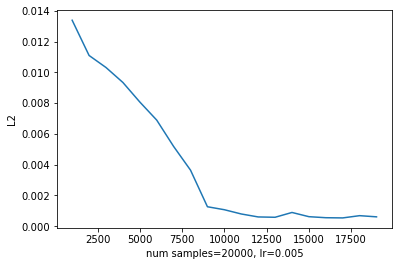

[0.013383004687726498, 0.011092351775616408, 0.010310579709708691, 0.009336793838068843, 0.008066813563928008, 0.006890143706463277, 0.005177249586675316, 0.003633967059315182, 0.0012562421457841992, 0.0010629571297031363, 0.0007861572696419898, 0.0005936652855452848, 0.0005718141634424682, 0.0008844298016047105, 0.0006102747949189506, 0.0005431143296591472, 0.0005300751263857819, 0.0006763145026634447, 0.0006000800461042672]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[-25 -20 -15 -10  -5   0   5  10  15  20  25]


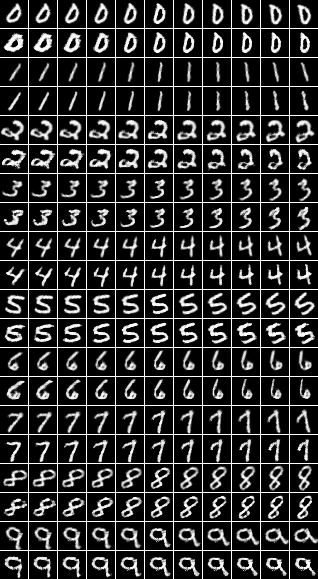

In [16]:
num_samples = 10

a = np.arange(-25,30,5)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -22.50, dist 0.01 +/- 0.00
alpha: -17.50, dist 0.01 +/- 0.00
alpha: -12.50, dist 0.01 +/- 0.00
alpha: -7.50, dist 0.01 +/- 0.00
alpha: -2.50, dist 0.01 +/- 0.00
alpha: 2.50, dist 0.01 +/- 0.00
alpha: 7.50, dist 0.01 +/- 0.00
alpha: 12.50, dist 0.01 +/- 0.00
alpha: 17.50, dist 0.00 +/- 0.00
alpha: 22.50, dist 0.00 +/- 0.00
2019-09-16 21:10:24,601 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-16 21:10:24,603 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


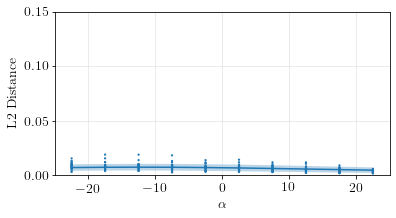

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'rot2d_aug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -25.00, dist 0.04 +/- 0.01
alpha: -20.00, dist 0.03 +/- 0.00
alpha: -15.00, dist 0.02 +/- 0.00
alpha: -10.00, dist 0.01 +/- 0.00
alpha: -5.00, dist 0.01 +/- 0.00
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 5.00, dist 0.01 +/- 0.00
alpha: 10.00, dist 0.01 +/- 0.00
alpha: 15.00, dist 0.02 +/- 0.00
alpha: 20.00, dist 0.03 +/- 0.00
alpha: 25.00, dist 0.04 +/- 0.01


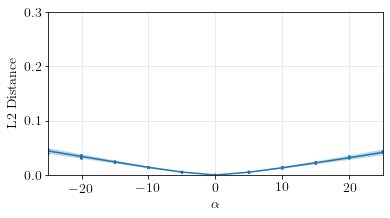

In [22]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'rot2d_aug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)